# Extract annotations and data from Mouse Genome Informatics database

The purpose of this notebook is to extract and format data for subsequent model annotation. 

Additionally, the purpose of this notebook is to extract relevant data to map between mouse and human homologs.

## Notebook Requirements:
*  Model genes **must** have the at least one of following annotations stored in the `object.annotation`. Values are expected to be seperated by semicolons. Accepted keys currently include:
    * `"uniprot"`
*  Note: Requires internet connection to download information from [MGI](https://www.informatics.jax.org/).

### Citations
Baldarelli RM, Smith CL, Ringwald M, Richardson JE, Bult CJ; Mouse Genome Informatics Group. Mouse Genome Informatics: an integrated knowledgebase system for the laboratory mouse. Genetics. 2024 May 7;227(1):iyae031. doi: 10.1093/genetics/iyae031. PMID: 38531069; PMCID: PMC11075557.

## Setup
### Import packages

In [1]:
import re

import matplotlib.pyplot as plt
import pandas as pd
from cobra.core.gene import GPR
from cobra.manipulation import remove_genes
from rbc_gem_utils import (
    GEM_NAME,
    build_string,
    check_database_release_online,
    compare_tables,
    get_annotation_df,
    get_dirpath,
    read_cobra_model,
    show_versions,
    split_string,
    visualize_comparison,
    write_cobra_model,
)
from rbc_gem_utils.database.mgi import (
    MGI_DB_TAG,
    MGI_RELEASE_EXPECTED,
    download_database_MGI,
)
from sympy import parse_expr

# Show versions of notebook
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Set notebook options

In [2]:
db_tag = MGI_DB_TAG
expected_release = MGI_RELEASE_EXPECTED
download_database = True

compare_figsize = (5, 5)
compare = True
display_nunique = True
overwrite = True

## Check MGI release
* If the current release does not match the expected release, it is because database has been updated since the last time this code was utilized.
    * If the notebook works without needing any significant modifications, the only update needed is to the release in the [mgi.py](../../src/rbc_gem_utils/database/complexportal.py) source code file to resolve the issue.

In [3]:
use_interim = not check_database_release_online(
    db_tag,
    verbose=True,
)
# Use different directory paths for unexpected behavior
if use_interim:
    warn(
        "Online release of database has been updated since the last time notebook was used."
    )

database_dirpath = get_dirpath(
    "database", db_tag, use_temp="interim" if use_interim else None
)
annotation_dirpath = get_dirpath(
    "annotation", use_temp="interim" if use_interim else None
)

# Ensure directories exist
database_dirpath.mkdir(exist_ok=True, parents=True)
annotation_dirpath.mkdir(exist_ok=True, parents=True)

Current and expected releases match. Current release: MGI 6.24, 04/25/2025


## Load Human-Mouse mapping tables
### Download from database

In [4]:
if download_database:
    download_database_MGI(
        [
            "HGNC_AllianceHomology.rpt",
            "MRK_SwissProt.rpt",  # Only reviewed proteins included
            "MRK_SwissProt_TrEMBL.rpt",  # Unreviewed proteins included
        ]
    )

### Set MIRIAM keys

In [5]:
mgi_key = "mgi"
hgnc_key = "hgnc"
hgnc_sym_key = f"{hgnc_key}.symbol"
mgnc_sym_key = "mgnc.symbol"  # Not currently a true miriam mapping
uniprot_key = "uniprot"
only_reviewed_proteins = True

header_len = 30
column_map = {
    "MGI Accession ID": mgi_key,
    "Marker Symbol": mgnc_sym_key,
    "HGNC ID": hgnc_key,
    "UniProt": f"{uniprot_key}.mouse",  # To distinguish from human,
}

### Load homology table

In [6]:
df_homology = pd.read_csv(
    database_dirpath / "HGNC_AllianceHomology.tsv",
    sep="\t",
    # TODO map additional columns for annotations
    index_col=False,
)
df_homology = df_homology[[x for x in column_map if x in df_homology.columns]]
df_homology = df_homology.rename(column_map, axis=1)
print(df_homology.nunique())
df_homology.head()

mgi            97469
mgnc.symbol    97469
hgnc           18403
dtype: int64


,mgi,mgnc.symbol,hgnc
0,MGI:87853,a,HGNC:745
1,MGI:87854,Pzp,NaN
2,MGI:87855,Aal,NaN
3,MGI:87859,Abl1,HGNC:76
4,MGI:87860,Abl2,HGNC:77


### Load protein table

In [7]:
if only_reviewed_proteins:
    prot_file = "MRK_SwissProt.tsv"
else:
    prot_file = "MRK_SwissProt_TrEMBL.tsv"

df_proteins = pd.read_csv(
    database_dirpath / prot_file,
    sep="\t",
    # TODO map additional columns for annotations
    index_col=False,
    header=None,
)
# Headers are not included, so label them using the website it from
df_proteins.columns = [
    "MGI Accession ID",
    "Marker Symbol",
    "Status",
    "Marker Name",
    "cM position",
    "Chromosome",
    "UniProt",  # SWISS-PROT Protein Accession IDs
]
df_proteins = df_proteins[[x for x in column_map if x in df_proteins.columns]]
df_proteins = df_proteins.rename(column_map, axis=1)

print(df_proteins.nunique())
df_proteins.head()

mgi              17027
mgnc.symbol      17027
uniprot.mouse    16984
dtype: int64


,mgi,mgnc.symbol,uniprot.mouse
0,MGI:1915614,0610030E20Rik,Q149G0
1,MGI:1915066,1110002E22Rik,E0CYV9
2,MGI:1929274,1110004F10Rik,Q9R0P4
3,MGI:1915975,1110032F04Rik,E9Q0B3
4,MGI:2152337,1110038F14Rik,Q3U6N9


### Create mapping table for all mouse genes/proteins to human genes

In [8]:
df_mouse_prots = df_homology.merge(
    df_proteins, left_on=mgi_key, right_on=mgi_key, how="left", suffixes=[None, "_drop"]
)
df_mouse_prots = df_mouse_prots.drop(
    [c for c in df_mouse_prots.columns if c.endswith("_drop")], axis=1
)
df_mouse_prots[f"{uniprot_key}.mouse"] = df_mouse_prots[
    f"{uniprot_key}.mouse"
].str.split(" ")
df_mouse_prots = df_mouse_prots.explode(f"{uniprot_key}.mouse")
print(
    "\n".join(
        ("Initial data table", "=" * header_len, str(df_mouse_prots.nunique()), "")
    )
)

# Original mapping is 1 mouse gene to 1+ human genes
# Drop entries without human gene mappings and rename Marker Symbol column
df_mouse_prots = df_mouse_prots[df_mouse_prots[hgnc_key].notna()]

# Remove prefixes from the IDs
df_mouse_prots[hgnc_key] = df_mouse_prots[hgnc_key].str.replace("HGNC:", "")
df_mouse_prots[mgi_key] = df_mouse_prots[mgi_key].str.replace("MGI:", "")
df_mouse_prots[hgnc_key] = df_mouse_prots[hgnc_key].str.split("|")
df_mouse_prots = df_mouse_prots.explode(hgnc_key).sort_values(hgnc_key)
print(
    "\n".join(
        (
            "Genes with human homologs",
            "=" * header_len,
            str(df_mouse_prots.nunique()),
            "",
        )
    )
)
df_mouse_prots

Initial data table
mgi              97469
mgnc.symbol      97469
hgnc             18403
uniprot.mouse    17051
dtype: int64

Genes with human homologs
mgi              20121
mgnc.symbol      20121
hgnc             19323
uniprot.mouse    16752
dtype: int64



,mgi,mgnc.symbol,hgnc,uniprot.mouse
5942,1194915,Asic1,100,Q6NXK8
5003,108409,Rgs4,10000,O08899
5717,1098434,Rgs5,10001,O08850
8379,1354730,Rgs6,10002,Q9Z2H2
7727,1346089,Rgs7,10003,O54829
...,...,...,...,...
20416,2180585,Rgs13,9995,Q8K443
8687,1859709,Rgs14,9996,P97492
5001,108407,Rgs16,9997,P97428
5705,1098271,Rgs2,9998,O08849


#### Summarize general mapping results

In [9]:
duplicated_count = df_mouse_prots[[hgnc_key, mgnc_sym_key]].drop_duplicates()
duplicated_count = duplicated_count[hgnc_key].duplicated(keep=False).value_counts()

duplicated_count = duplicated_count.rename(
    {False: "One to One map ", True: "One to Many map "}, axis=0
)
duplicated_count.index.name = None
duplicated_count.name = None
print(
    "\n".join(("Human to Mouse mapping", "=" * header_len, str(duplicated_count), ""))
)

Human to Mouse mapping
One to One map      18068
One to Many map      6518
dtype: int64



## Map to RBC-GEM
### Load RBC-GEM model

In [10]:
model_dirpath = get_dirpath("model")
model = read_cobra_model(filename=model_dirpath / f"{GEM_NAME}.xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21


Name,RBC_GEM
Memory address,14dceb910
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


### Create model mapping table from annotations

In [11]:
df_model = get_annotation_df(model.genes, [uniprot_key, hgnc_key, hgnc_sym_key]).rename(
    {"id": "genes"}, axis=1
)
df_model[hgnc_key] = df_model[hgnc_key].str.split(";")
df_model = df_model.explode(hgnc_key).sort_values(hgnc_key)
df_model = df_model.merge(
    df_mouse_prots, left_on=hgnc_key, right_on=hgnc_key, how="left"
)
print("\n".join(("Mapped to model", "=" * header_len, str(df_model.nunique()), "")))

duplicated_count = df_model[[hgnc_key, mgnc_sym_key]].drop_duplicates()
duplicated_count = duplicated_count[hgnc_key].duplicated(keep=False).value_counts()

duplicated_count = duplicated_count.rename(
    {False: "One to One map ", True: "One to Many map "}, axis=0
)
duplicated_count.index.name = None
duplicated_count.name = None
print(
    "\n".join(("Human to Mouse mapping", "=" * header_len, str(duplicated_count), ""))
)

Mapped to model
genes            820
uniprot          820
hgnc             821
hgnc.symbol      820
mgi              864
mgnc.symbol      864
uniprot.mouse    824
dtype: int64

Human to Mouse mapping
One to One map      784
One to Many map      98
dtype: int64



### Format for human model annotations

genes: 820
uniprot: 820
hgnc: 821
hgnc.symbol: 821
mgi: 864


,genes,uniprot,hgnc,hgnc.symbol,mgi
0,A4GALT,Q9NPC4,18149,A4GALT,3512453
1,AARS1,P49588,20,AARS1,2384560
2,AASDHPPT,Q9NRN7,14235,AASDHPPT,1914868
3,ABCA1,O95477,29,ABCA1,99607
4,ABCA7,Q8IZY2,37,ABCA7,1351646
...,...,...,...,...,...
815,YES1,P07947,12841,YES1,99147
816,ZDHHC2,Q9UIJ5,18469,ZDHHC2,1923452
817,ZDHHC20,Q5W0Z9,20749,ZDHHC20,1923215
818,ZDHHC3,Q9NYG2,18470,ZDHHC3,1926134


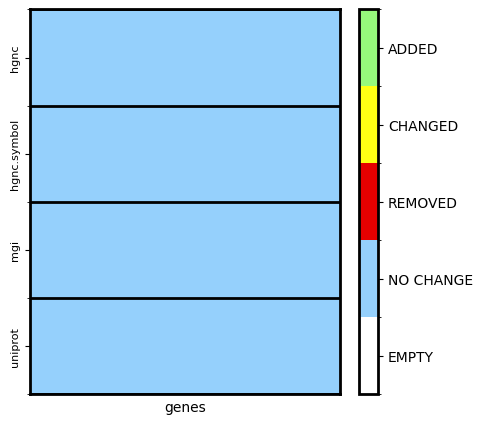

In [12]:
df_annotations = df_model.replace(pd.NA, "")
df_annotations = df_annotations.groupby("genes", as_index=False)[
    [uniprot_key, hgnc_key, hgnc_sym_key, mgi_key]
].agg(lambda x: build_string(x))
df_annotations = df_annotations.replace("", pd.NA)

annotation_type = "genes"
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            annotation_dirpath / f"{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")
if overwrite:
    df_annotations.to_csv(
        annotation_dirpath / f"{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )

df_annotations

In [13]:
map_to_na_gene = df_model[df_model[mgnc_sym_key].isna()]
map_to_na_gene = map_to_na_gene[
    ["genes", mgnc_sym_key, f"{uniprot_key}.mouse"]
].drop_duplicates()
map_to_na_gene = map_to_na_gene.sort_values([mgnc_sym_key, f"{uniprot_key}.mouse"])

print(
    "\n".join(
        (
            "No identified mouse gene",
            "=" * header_len,
            str(map_to_na_gene.nunique()),
            "",
        )
    )
)

map_to_na_protein = df_model[df_model[f"{uniprot_key}.mouse"].isna()]
map_to_na_protein = map_to_na_protein[
    ["genes", mgnc_sym_key, f"{uniprot_key}.mouse"]
].drop_duplicates()
map_to_na_protein = map_to_na_protein.sort_values(
    [mgnc_sym_key, f"{uniprot_key}.mouse"]
)

print(
    "\n".join(
        (
            "No identified mouse protein",
            "=" * header_len,
            str(map_to_na_protein.nunique()),
            "",
        )
    )
)
df_model = df_model.dropna(subset=[mgnc_sym_key, f"{uniprot_key}.mouse"])
gene_mapping = df_model.groupby(["genes"])[mgnc_sym_key].agg(lambda x: list(x))
gene_mapping = gene_mapping.to_dict()

No identified mouse gene
genes            3
mgnc.symbol      0
uniprot.mouse    0
dtype: int64

No identified mouse protein
genes            33
mgnc.symbol      40
uniprot.mouse     0
dtype: int64



### Update gene reaction rules

In [14]:
mouse_model = model.copy()
new_gprs = {}
for i, reaction in enumerate(
    mouse_model.reactions.query(lambda x: x.gene_reaction_rule)
):
    gene_reaction_rule = reaction.gene_reaction_rule
    for gene in reaction.genes:
        try:
            replacements = gene_mapping[gene.id]
        except KeyError as e:
            replacements = "TO_REMOVE"
        else:
            replacements = " or ".join(replacements)
        # Replace all matches, be mindful of partial gene ID replacements by searching by ensuring no trailing alphanumeric characters
        gene_reaction_rule = re.subn(
            f"{gene.id}(?![a-zA-Z0-9_])", replacements, gene_reaction_rule
        )[0]

    gene_reaction_rule = (
        gene_reaction_rule.replace("-", "_")
        .replace(" or ", "|")
        .replace(" and ", " & ")
    )
    gene_reaction_rule = parse_expr(gene_reaction_rule)
    reaction.gpr = GPR.from_symbolic(gene_reaction_rule)

# Remove old model genes
remove_genes(
    mouse_model,
    gene_list=["TO_REMOVE"] + model.genes.list_attr("id"),
    remove_reactions=False,
)
mouse_model

Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmp20nsk5xm.lp
Reading time = 0.02 seconds
: 2157 rows, 6550 columns, 24874 nonzeros


Name,RBC_GEM
Memory address,15038de90
Number of metabolites,2157
Number of reactions,3275
Number of genes,824
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


### Update annotations for new genes

In [15]:
df_mouse_annotations = df_model.groupby(mgnc_sym_key)[
    [mgi_key, f"{uniprot_key}.mouse", hgnc_key, hgnc_sym_key]
].agg(lambda x: build_string(x))
df_mouse_annotations = df_mouse_annotations.rename(
    {f"{uniprot_key}.mouse": uniprot_key}, axis=1
)
df_mouse_annotations.index = df_mouse_annotations.index.str.replace("-", "_")
for gene in mouse_model.genes:
    annotation = {mgnc_sym_key: gene.id}
    annotation.update(df_mouse_annotations.loc[gene.id].to_dict())
    gene.annotation.update(annotation)
df_mouse_annotations

,mgi,uniprot,hgnc,hgnc.symbol
mgnc.symbol,,,,
A4galt,3512453,Q67BJ4,18149,A4GALT
Aars1,2384560,Q8BGQ7,20,AARS1
Aasdhppt,1914868,Q9CQF6,14235,AASDHPPT
Abca1,99607,P41233,29,ABCA1
Abca7,1351646,Q91V24,37,ABCA7
...,...,...,...,...
Yes1,99147,Q04736,12841,YES1
Zdhhc2,1923452,P59267,18469,ZDHHC2
Zdhhc20,1923215,Q5Y5T1,20749,ZDHHC20


## Export model and data mapping tables

In [16]:
write_cobra_model(mouse_model, filename=database_dirpath / f"{mouse_model.id}.xml")
df_model.to_csv(database_dirpath / "HumanMouseMapping.tsv", sep="\t", index=False)
df_model

,genes,uniprot,hgnc,hgnc.symbol,mgi,mgnc.symbol,uniprot.mouse
0,RHAG,Q02094,10006,RHAG,1202713,Rhag,Q9QUT0
1,RHCE,P18577,10008,RHCE,1202882,Rhd,Q8CF94
2,RHD,Q02161,10009,RHD,1202882,Rhd,Q8CF94
3,ROCK2,O75116,10252,ROCK2,107926,Rock2,P70336
4,RPE,Q96AT9,10293,RPE,1913896,Rpe,Q8VEE0
...,...,...,...,...,...,...,...
876,RAN,P62826,9846,RAN,1333112,Ran,P62827
877,RAP1A,P62834,9855,RAP1A,97852,Rap1a,P62835
878,RAP2B,P61225,9862,RAP2B,1921262,Rap2b,P61226
879,RARS1,P54136,9870,RARS1,1914297,Rars1,Q9D0I9


## Download sequence data from UniProt

In [17]:
from rbc_gem_utils import GEM_NAME
from rbc_gem_utils.database.uniprot import (
    UNIPROT_API_URL,
    UNIPROT_DB_TAG,
    UNIPROT_PATH,
    UNIPROT_RELEASE_EXPECTED,
    get_annotation_to_from_db_UniProt,
    get_isoform_value_from_entry_UniProt,
    get_label_miriam_mapping_UniProt,
    get_query_fields_UniProt,
    get_release_UniProt,
    parse_chains_UniProt,
    parse_isoforms_UniProt,
    query_UniProt,
)

### Get IDs for query
#### Using an existing annotation

In [18]:
annotation_type = "genes"
annotation_cols = ["uniprot"]
mapping_key = "uniprot"

df_model_mappings = (
    get_annotation_df(mouse_model.genes, annotation_cols)
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)
for col in df_model_mappings.columns:
    df_model_mappings[col] = df_model_mappings[col].apply(lambda x: split_string(x))
    df_model_mappings = df_model_mappings.explode(col).drop_duplicates().dropna()
df_model_mappings = df_model_mappings.sort_values(annotation_type)

print(df_model_mappings.nunique(dropna=True))
df_model_mappings = df_model_mappings.reset_index(drop=True)
df_model_mappings

genes      824
uniprot    824
dtype: int64


,genes,uniprot
0,A4galt,Q67BJ4
1,Aars1,Q8BGQ7
2,Aasdhppt,Q9CQF6
3,Abca1,P41233
4,Abca7,Q91V24
...,...,...
819,Yes1,Q04736
820,Zdhhc2,P59267
821,Zdhhc20,Q5Y5T1
822,Zdhhc3,Q8R173


In [19]:
annotation_to_from_db = get_annotation_to_from_db_UniProt(miriam_only=True)

from_db = annotation_to_from_db[mapping_key]
query_ids = df_model_mappings[mapping_key].dropna().unique()
assert len(set(query_ids)) == len(query_ids), "Duplicate IDs in list to query"
model_search_mapping = df_model_mappings.set_index(annotation_type)[
    mapping_key
].to_dict()
print(f"Number of model genes associated with query: {len(model_search_mapping)}")
print(f"Number of unique IDs to query: {len(query_ids)}")
df_model_mappings[[annotation_type, mapping_key]].drop_duplicates()

Number of model genes associated with query: 824
Number of unique IDs to query: 824


,genes,uniprot
0,A4galt,Q67BJ4
1,Aars1,Q8BGQ7
2,Aasdhppt,Q9CQF6
3,Abca1,P41233
4,Abca7,Q91V24
...,...,...
819,Yes1,Q04736
820,Zdhhc2,P59267
821,Zdhhc20,Q5Y5T1
822,Zdhhc3,Q8R173


### Run queries
#### Set universal query parameters

In [20]:
all_query_results = {}
miriam_query_fields = get_query_fields_UniProt(miriam_only=True)
query_fields = miriam_query_fields + [
    # Add additional non-miriam fields if desired
    # Complex composition
    "cc_subunit",
    # Specific isoforms to include/avoid
    "cc_tissue_specificity",
    "cc_subcellular_location",
    # Chromosome
    "xref_proteomes",
]

# Extract all relevant information for now and save
query_parameters = {
    "query": " && ".join(
        [
            "(reviewed:true)",
            "(organism_id:10090)",  # Homo sapiens (Human)
        ]
    ),
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(query_fields),
}

#### Initial query

In [21]:
query_key = "initial"
df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    list(query_ids),
    query_parameters=query_parameters,
    to_db="UniProtKB",
    from_db=from_db,
    return_failed=True,
)
if failed_ids:
    print(failed_ids)
all_query_results[query_key] = df_results
df_results

Fetched: 500 / 823


Number of failed query IDs : 1


Fetched: 823 / 823


Number of obsolete IDs : 1


,From,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,...,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Subunit structure,Tissue specificity,Subcellular location [CC],Proteomes
0,A1L3P4,A1L3P4,Slc9a6,10090,ALTERNATIVE PRODUCTS:,,RHEA:29419 RHEA:29467,UPI0000435B9F,GO:0005739; GO:0005768; GO:0005769; GO:0005770...,"CHAIN 1..702; /note=""Sodium/hydrogen exchanger...",...,PF00999;,,PR01084;PR01088;,,,,SUBUNIT: Homodimer. Interacts with RACK1; regu...,,SUBCELLULAR LOCATION: Endosome membrane {ECO:0...,UP000000589: Chromosome X
1,A2A432,A2A432,Cul4b,10090,ALTERNATIVE PRODUCTS: Event=Alternative splic...,,,UPI0000DBEDD2,GO:0000209; GO:0003684; GO:0005634; GO:0005654...,"CHAIN 1..970; /note=""Cullin-4B""; /id=""PRO_0000...",...,PF00888;PF10557;,,,PS01256;PS50069;,SM00182;SM00884;,SSF75632;SSF74788;SSF46785;,SUBUNIT: Component of multiple DCX (DDB1-CUL4-...,TISSUE SPECIFICITY: Expressed in oocytes (at p...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,UP000000589: Chromosome X
2,A2ALK8,A2ALK8,Ptpn3,10090,ALTERNATIVE PRODUCTS:,3.1.3.48,RHEA:10684,UPI000059DF93,GO:0001784; GO:0004725; GO:0004726; GO:0005737...,"CHAIN 1..913; /note=""Tyrosine-protein phosphat...",...,PF09380;PF00373;PF09379;PF00595;PF00102;,PIRSF000927;,PR00935;PR00700;,PS00661;PS50057;PS50106;PS00383;PS50056;PS50055;,SM00295;SM01196;SM00228;SM00194;SM00404;,SSF52799;SSF50156;SSF50729;SSF47031;SSF54236;,,,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,UP000000589: Chromosome 4
3,A2AN08,A2AN08,Ubr4,10090,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.3.2.27,,UPI000059E299,GO:0005516; GO:0005634; GO:0005768; GO:0005856...,"CHAIN 1..5180; /note=""E3 ubiquitin-protein lig...",...,PF13764;PF19423;PF24079;PF02207;,,,PS52043;PS51157;,SM00396;,SSF48371;SSF50978;,"SUBUNIT: Component of the SIFI complex, compos...",TISSUE SPECIFICITY: Widely expressed in adult ...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000250|U...,UP000000589: Chromosome 4
4,A2AVZ9,A2AVZ9,Slc43a3,10090,ALTERNATIVE PRODUCTS: Event=Alternative splic...,,RHEA:71523 RHEA:71531 RHEA:71515,UPI00001EF3B4,GO:0015207; GO:0015208; GO:0015245; GO:0016323...,"CHAIN 1..502; /note=""Equilibrative nucleobase ...",...,PF07690;,,,,,SSF103473;,,TISSUE SPECIFICITY: High expression in the hea...,SUBCELLULAR LOCATION: Basolateral cell membran...,UP000000589: Chromosome 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,Q9Z2L6,Q9Z2L6,Minpp1,10090,ALTERNATIVE PRODUCTS:,3.1.3.62; 3.1.3.80,RHEA:16989 RHEA:77115 RHEA:77119 RHEA:77131 RH...,UPI0000022487,GO:0004446; GO:0005615; GO:0005788; GO:0005886...,"CHAIN 31..481; /note=""Multiple inositol polyph...",...,PF00328;,PIRSF000894;,,PS00014;,,SSF53254;,,TISSUE SPECIFICITY: Widely expressed with high...,SUBCELLULAR LOCATION: Endoplasmic reticulum lu...,UP000000589: Chromosome 19
819,Q9Z2M7,Q9Z2M7,Pmm2,10090,ALTERNATIVE PRODUCTS:,5.4.2.8,RHEA:11140,UPI0000003E9F,GO:0004615; GO:0005654; GO:0005737; GO:0005829...,"CHAIN 1..242; /note=""Phosphomannomutase 2""; /i...",...,PF03332;,,,,,SSF56784;,SUBUNIT: Homodimer. {ECO:0000250}.,,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000250}.,UP000000589: Chromosome 16
820,Q9Z2V4,Q9Z2V4,Pck1,10090,ALTERNATIVE PRODUCTS:,2.7.11.-; 4.1.1.32,RHEA:10388 RHEA:64020,UPI0000003F54,GO:0000287; GO:0004611; GO:0004613; GO:0005525...,"CHAIN 1..622; /note=""Phosphoenolpyruvate carbo...",...,PF00821;PF17297;,PIRSF001348;,,PS00505;,,SSF68923;SSF53795;,SUBUNIT: Monomer. {ECO:0000250|UniProtKB:P35558}.,,"SUBCELLULAR LOCATION: Cytoplasm, cytosol {ECO:...",UP000000589: Chromosome 2
821,Q9Z2W0,Q9Z2W0,Dnpep,10090,ALTERNATIVE PRODUCTS:,3.4.11.21,,UPI000002282D,GO:0004177; GO:0005737; GO:0006508; GO:0008237...,"CHAIN 1..473; /note=""Aspartyl aminopeptidase"";...",...,PF02127;,,PR00932;,,,SSF101821;SSF53187;,SUBUNIT: Tetrahedron-shaped homododecamer buil...,TISSUE SPECIFICITY: Ubiquitous.,SUBCELLULAR LOCATION: Cytoplasm.,UP000000589: Chromosome 1


### Address failed IDs

In [22]:
# retry_ids = {}
# query_key = "retry_1"
# df_results, failed_ids = query_UniProt(
#     list(sorted(retry_ids.values())),
#     from_db="UniProtKB",
#     query_parameters=query_parameters
# )
# if failed_ids:
#     print(failed_ids)
# all_query_results[query_key] = df_results
# model_search_mapping.update({
#     k: retry_ids[v] for k, v in model_search_mapping.items()
#     if v in retry_ids and v not in failed_ids
# })
# df_results

## Concat, cleanup, and save query results

In [23]:
print(f"Number of unique queries: {len(all_query_results)}")
df_query_results = pd.concat(tuple(all_query_results.values()))
df_query_results = df_query_results.set_index("From").drop_duplicates()
df_query_results = df_query_results.replace("", pd.NA)
df_query_results

Number of unique queries: 1


,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,PubMed ID,...,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Subunit structure,Tissue specificity,Subcellular location [CC],Proteomes
From,,,,,,,,,,,,,,,,,,,,,
A1L3P4,A1L3P4,Slc9a6,10090,ALTERNATIVE PRODUCTS:,<NA>,RHEA:29419 RHEA:29467,UPI0000435B9F,GO:0005739; GO:0005768; GO:0005769; GO:0005770...,"CHAIN 1..702; /note=""Sodium/hydrogen exchanger...",16141072; 19468303; 15489334; 19144319; 211830...,...,PF00999;,<NA>,PR01084;PR01088;,<NA>,<NA>,<NA>,SUBUNIT: Homodimer. Interacts with RACK1; regu...,<NA>,SUBCELLULAR LOCATION: Endosome membrane {ECO:0...,UP000000589: Chromosome X
A2A432,A2A432,Cul4b,10090,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,<NA>,UPI0000DBEDD2,GO:0000209; GO:0003684; GO:0005634; GO:0005654...,"CHAIN 1..970; /note=""Cullin-4B""; /id=""PRO_0000...",16052071; 16141072; 19468303; 15489334; 124657...,...,PF00888;PF10557;,<NA>,<NA>,PS01256;PS50069;,SM00182;SM00884;,SSF75632;SSF74788;SSF46785;,SUBUNIT: Component of multiple DCX (DDB1-CUL4-...,TISSUE SPECIFICITY: Expressed in oocytes (at p...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,UP000000589: Chromosome X
A2ALK8,A2ALK8,Ptpn3,10090,ALTERNATIVE PRODUCTS:,3.1.3.48,RHEA:10684,UPI000059DF93,GO:0001784; GO:0004725; GO:0004726; GO:0005737...,"CHAIN 1..913; /note=""Tyrosine-protein phosphat...",19468303; 21183079,...,PF09380;PF00373;PF09379;PF00595;PF00102;,PIRSF000927;,PR00935;PR00700;,PS00661;PS50057;PS50106;PS00383;PS50056;PS50055;,SM00295;SM01196;SM00228;SM00194;SM00404;,SSF52799;SSF50156;SSF50729;SSF47031;SSF54236;,<NA>,<NA>,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,UP000000589: Chromosome 4
A2AN08,A2AN08,Ubr4,10090,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.3.2.27,<NA>,UPI000059E299,GO:0005516; GO:0005634; GO:0005768; GO:0005856...,"CHAIN 1..5180; /note=""E3 ubiquitin-protein lig...",16141072; 19468303; 15489334; 16055722; 160815...,...,PF13764;PF19423;PF24079;PF02207;,<NA>,<NA>,PS52043;PS51157;,SM00396;,SSF48371;SSF50978;,"SUBUNIT: Component of the SIFI complex, compos...",TISSUE SPECIFICITY: Widely expressed in adult ...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000250|U...,UP000000589: Chromosome 4
A2AVZ9,A2AVZ9,Slc43a3,10090,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,RHEA:71523 RHEA:71531 RHEA:71515,UPI00001EF3B4,GO:0015207; GO:0015208; GO:0015245; GO:0016323...,"CHAIN 1..502; /note=""Equilibrative nucleobase ...",11704567; 16141072; 19468303; 15489334; 211830...,...,PF07690;,<NA>,<NA>,<NA>,<NA>,SSF103473;,<NA>,TISSUE SPECIFICITY: High expression in the hea...,SUBCELLULAR LOCATION: Basolateral cell membran...,UP000000589: Chromosome 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2L6,Q9Z2L6,Minpp1,10090,ALTERNATIVE PRODUCTS:,3.1.3.62; 3.1.3.80,RHEA:16989 RHEA:77115 RHEA:77119 RHEA:77131 RH...,UPI0000022487,GO:0004446; GO:0005615; GO:0005788; GO:0005886...,"CHAIN 31..481; /note=""Multiple inositol polyph...",10087200; 16141072; 15489334; 10938126; 211830...,...,PF00328;,PIRSF000894;,<NA>,PS00014;,<NA>,SSF53254;,<NA>,TISSUE SPECIFICITY: Widely expressed with high...,SUBCELLULAR LOCATION: Endoplasmic reticulum lu...,UP000000589: Chromosome 19
Q9Z2M7,Q9Z2M7,Pmm2,10090,ALTERNATIVE PRODUCTS:,5.4.2.8,RHEA:11140,UPI0000003E9F,GO:0004615; GO:0005654; GO:0005737; GO:0005829...,"CHAIN 1..242; /note=""Phosphomannomutase 2""; /i...",11404002; 15489334; 21183079; 23806337,...,PF03332;,<NA>,<NA>,<NA>,<NA>,SSF56784;,SUBUNIT: Homodimer. {ECO:0000250}.,<NA>,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000250}.,UP000000589: Chromosome 16
Q9Z2V4,Q9Z2V4,Pck1,10090,ALTERNATIVE PRODUCTS:,2.7.11.-; 4.1.1.32,RHEA:10388 RHEA:64020,UPI0000003F54,GO:0000287; GO:0004611; GO:0004613; GO:0005525...,"CHAIN 1..622; /note=""Phosphoenolpyruvate carbo...",10221772; 16141072; 10938127; 11916968; 117928...,...,PF00821;PF17297;,PIRSF001348;,<NA>,PS00505;,<NA>,SSF68923;SSF53795;,SUBUNIT: Monomer. {ECO:0000

#### Save extracted data to database

,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,PubMed ID,...,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Subunit structure,Tissue specificity,Subcellular location [CC],Proteomes
0,A1L3P4,Slc9a6,10090,ALTERNATIVE PRODUCTS:,<NA>,RHEA:29419 RHEA:29467,UPI0000435B9F,GO:0005739; GO:0005768; GO:0005769; GO:0005770...,"CHAIN 1..702; /note=""Sodium/hydrogen exchanger...",16141072; 19468303; 15489334; 19144319; 211830...,...,PF00999;,<NA>,PR01084;PR01088;,<NA>,<NA>,<NA>,SUBUNIT: Homodimer. Interacts with RACK1; regu...,<NA>,SUBCELLULAR LOCATION: Endosome membrane {ECO:0...,UP000000589: Chromosome X
1,A2A432,Cul4b,10090,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,<NA>,UPI0000DBEDD2,GO:0000209; GO:0003684; GO:0005634; GO:0005654...,"CHAIN 1..970; /note=""Cullin-4B""; /id=""PRO_0000...",16052071; 16141072; 19468303; 15489334; 124657...,...,PF00888;PF10557;,<NA>,<NA>,PS01256;PS50069;,SM00182;SM00884;,SSF75632;SSF74788;SSF46785;,SUBUNIT: Component of multiple DCX (DDB1-CUL4-...,TISSUE SPECIFICITY: Expressed in oocytes (at p...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,UP000000589: Chromosome X
2,A2ALK8,Ptpn3,10090,ALTERNATIVE PRODUCTS:,3.1.3.48,RHEA:10684,UPI000059DF93,GO:0001784; GO:0004725; GO:0004726; GO:0005737...,"CHAIN 1..913; /note=""Tyrosine-protein phosphat...",19468303; 21183079,...,PF09380;PF00373;PF09379;PF00595;PF00102;,PIRSF000927;,PR00935;PR00700;,PS00661;PS50057;PS50106;PS00383;PS50056;PS50055;,SM00295;SM01196;SM00228;SM00194;SM00404;,SSF52799;SSF50156;SSF50729;SSF47031;SSF54236;,<NA>,<NA>,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,UP000000589: Chromosome 4
3,A2AN08,Ubr4,10090,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.3.2.27,<NA>,UPI000059E299,GO:0005516; GO:0005634; GO:0005768; GO:0005856...,"CHAIN 1..5180; /note=""E3 ubiquitin-protein lig...",16141072; 19468303; 15489334; 16055722; 160815...,...,PF13764;PF19423;PF24079;PF02207;,<NA>,<NA>,PS52043;PS51157;,SM00396;,SSF48371;SSF50978;,"SUBUNIT: Component of the SIFI complex, compos...",TISSUE SPECIFICITY: Widely expressed in adult ...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000250|U...,UP000000589: Chromosome 4
4,A2AVZ9,Slc43a3,10090,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,RHEA:71523 RHEA:71531 RHEA:71515,UPI00001EF3B4,GO:0015207; GO:0015208; GO:0015245; GO:0016323...,"CHAIN 1..502; /note=""Equilibrative nucleobase ...",11704567; 16141072; 19468303; 15489334; 211830...,...,PF07690;,<NA>,<NA>,<NA>,<NA>,SSF103473;,<NA>,TISSUE SPECIFICITY: High expression in the hea...,SUBCELLULAR LOCATION: Basolateral cell membran...,UP000000589: Chromosome 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,Q9Z2L6,Minpp1,10090,ALTERNATIVE PRODUCTS:,3.1.3.62; 3.1.3.80,RHEA:16989 RHEA:77115 RHEA:77119 RHEA:77131 RH...,UPI0000022487,GO:0004446; GO:0005615; GO:0005788; GO:0005886...,"CHAIN 31..481; /note=""Multiple inositol polyph...",10087200; 16141072; 15489334; 10938126; 211830...,...,PF00328;,PIRSF000894;,<NA>,PS00014;,<NA>,SSF53254;,<NA>,TISSUE SPECIFICITY: Widely expressed with high...,SUBCELLULAR LOCATION: Endoplasmic reticulum lu...,UP000000589: Chromosome 19
819,Q9Z2M7,Pmm2,10090,ALTERNATIVE PRODUCTS:,5.4.2.8,RHEA:11140,UPI0000003E9F,GO:0004615; GO:0005654; GO:0005737; GO:0005829...,"CHAIN 1..242; /note=""Phosphomannomutase 2""; /i...",11404002; 15489334; 21183079; 23806337,...,PF03332;,<NA>,<NA>,<NA>,<NA>,SSF56784;,SUBUNIT: Homodimer. {ECO:0000250}.,<NA>,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000250}.,UP000000589: Chromosome 16
820,Q9Z2V4,Pck1,10090,ALTERNATIVE PRODUCTS:,2.7.11.-; 4.1.1.32,RHEA:10388 RHEA:64020,UPI0000003F54,GO:0000287; GO:0004611; GO:0004613; GO:0005525...,"CHAIN 1..622; /note=""Phosphoenolpyruvate carbo...",10221772; 16141072; 10938127; 11916968; 117928...,...,PF00821;PF17297;,PIRSF001348;,<NA>,PS00505;,<NA>,SSF68923;SSF53795;,SUBUNIT: Monomer. {ECO:0000250|UniProtKB:P35558}.,<NA>,"SUBCELLULAR LOCATION: Cytoplasm

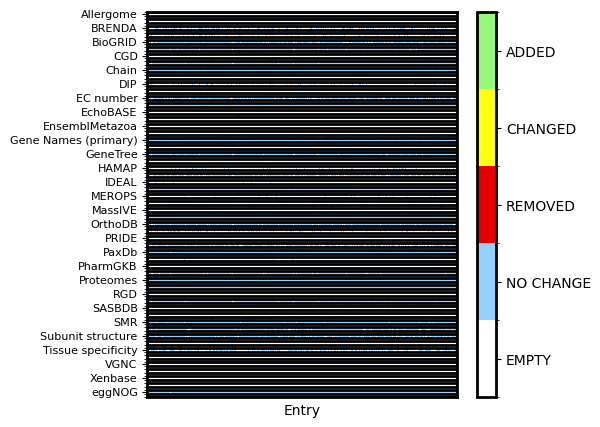

In [24]:
# Save query results to external database
df_database = df_query_results.reset_index(drop=True).drop_duplicates()
if compare:
    compare_on_index = ["Entry"]
    try:
        df_previous = pd.read_csv(
            database_dirpath / f"{db_tag}_{GEM_NAME}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index), df_database.set_index(compare_on_index)
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_database.to_csv(
        database_dirpath / f"{db_tag}_{GEM_NAME}.tsv", sep="\t", index=False
    )

df_database

## Format UniProt information for annotation files
### Genes
#### Map to chosen MIRIAMs
As formatting may be needed for some MIRIAMS, keep it simple for now until formatting methods are developed. 

In [25]:
annotation_type = "genes"

# Keeping it simple for now, group items regardless of isoforms for the time being
uniprot_miriam_mapping = get_label_miriam_mapping_UniProt(
    get_query_fields_UniProt(miriam_only=True)
)
uniprot_miriam_mapping["Proteomes"] = "chromosome"

merge_key = {
    v: k for k, v in uniprot_miriam_mapping.items() if v in df_model_mappings.columns
}[mapping_key]
df_annotations = df_model_mappings.set_index(mapping_key).merge(
    df_database, left_index=True, right_on=merge_key, how="inner"
)
df_annotations = (
    df_annotations.set_index(annotation_type)
    .loc[:, list(uniprot_miriam_mapping)]
    .rename(uniprot_miriam_mapping, axis=1)
)
uniprot_columns = ["uniprot", "uniprot.isoform", "uniprot.chain"]
# For the most part, these columns do not require any reformatting or are easy to work with.
annotation_columns = [
    "hgnc.symbol",
    "ec-code",
    "taxonomy",
    "uniparc",
    # Reactions
    "rhea",
    # Gene Ontology (GO)
    "go",
    # Sequence
    "ccds",
    "ena.embl",
    "refseq",
    # 3D Structure
    "bmrb",
    "pdb",
    "sasbdb",
    "smr",
    # Protein-protein interaction
    "biogrid",
    "complexportal",
    "dip",
    "intact",
    # Chemistry databases
    "chembl.target",
    "drugbank",
    "iuphar.receptor",
    # Protein family/group databases
    "cazy",
    "ideal",
    "merops",
    "peroxibase",
    "tcdb",
    # Genetic variation/Polymorphism and mutation databases
    "dbsnp",
    # Proteomic databases
    "proteomicsdb.protein",
    # Genome annotation databases
    "ensembl",
    "ncbigene",
    ## Organism-specific
    "kegg.genes",
    "genecards",
    "hgnc",
    "hpa",
    "mim",
    "nextprot",
    "orphanet",
    "pharmgkb.gene",
    # Phylogenomic databases
    "eggnog",
    "genetree",
    "hogenom",
    "oma.grp",
    "orthodb",
    "treefam",
    # Enzyme and pathway databases
    "biocyc",
    "brenda",
    "reactome",
    # Miscellaneous databases
    "genewiki",
    # Gene expression databases
    "bgee.gene",
    ## Family and domain databases
    "cdd",
    "disprot",
    "hamap",
    "interpro",
    "panther.family",
    "pfam",
    "pirsf",
    "prints",
    "prosite",
    "smart",
    "supfam",
    "chromosome",
]
df_annotations["chromosome"] = df_annotations["chromosome"].apply(
    lambda x: x.split(" ")[-1]
)
df_annotations = df_annotations.loc[:, uniprot_columns + annotation_columns].rename(
    {
        "hgnc.symbol": "mgnc.symbol",  # Rename for mouse
    },
    axis=1,
)
annotation_columns[annotation_columns.index("hgnc.symbol")] = "mgnc.symbol"
print(f"Fields searched: {df_annotations.shape[1]}")
all_na = df_annotations.T[df_annotations.isna().all(axis=0)].index
annotation_columns = [x for x in annotation_columns if x not in all_na]
df_annotations = df_annotations.dropna(how="all", axis=1)
print(f"Empty dropped: {len(all_na)}")
print(f"Remaining: {df_annotations.shape[1]}")
df_annotations = df_annotations.reset_index(drop=False).replace(pd.NA, "")
df_annotations

Fields searched: 63
Empty dropped: 11
Remaining: 52


,genes,uniprot,uniprot.isoform,uniprot.chain,mgnc.symbol,ec-code,taxonomy,uniparc,rhea,go,...,hamap,interpro,panther.family,pfam,pirsf,prints,prosite,smart,supfam,chromosome
0,A4galt,Q67BJ4,ALTERNATIVE PRODUCTS:,"CHAIN 1..359; /note=""Lactosylceramide 4-alpha-...",A4galt,2.4.1.228,10090,UPI0000026A84,RHEA:11924 RHEA:60044,GO:0000139; GO:0001576; GO:0007009; GO:0008378...,...,,IPR007652;IPR051981;IPR007577;IPR029044;,PTHR12042:SF17;PTHR12042;,PF04572;PF04488;,,,,,SSF53448;,15
1,Aars1,Q8BGQ7,ALTERNATIVE PRODUCTS:,"CHAIN 1..968; /note=""Alanine--tRNA ligase, cyt...",Aars1,6.-.-.-; 6.1.1.7,10090,UPI00000EB9CC,RHEA:12540 RHEA:80271 RHEA:80275,GO:0000049; GO:0002161; GO:0002196; GO:0004813...,...,MF_00036_B;,IPR045864;IPR002318;IPR018162;IPR018165;IPR018...,PTHR11777:SF36;PTHR11777;,PF02272;PF01411;PF07973;,,PR00980;,PS50860;,SM00863;,SSF55681;SSF101353;SSF55186;SSF50447;,8
2,Aasdhppt,Q9CQF6,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..309; /note=""L-aminoadipate-semialdehy...",Aasdhppt,2.7.8.7,10090,UPI000002272C,RHEA:12068 RHEA:46564,GO:0000287; GO:0005829; GO:0008897; GO:0009258...,...,,IPR008278;IPR037143;IPR055066;IPR050559;,PTHR12215:SF10;PTHR12215;,PF22624;PF01648;,,,,,SSF56214;,9
3,Abca1,P41233,ALTERNATIVE PRODUCTS:,"CHAIN 1..2261; /note=""Phospholipid-transportin...",Abca1,7.6.2.1,10090,UPI0000022E5F,RHEA:38583 RHEA:38567 RHEA:38903 RHEA:39051,GO:0002790; GO:0005102; GO:0005524; GO:0005548...,...,,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229:SF250;PTHR19229;,PF12698;PF00005;PF23321;,,,PS00211;PS50893;,SM00382;,SSF52540;,4
4,Abca7,Q91V24,ALTERNATIVE PRODUCTS:,"CHAIN 1..2159; /note=""ATP-binding cassette sub...",Abca7,,10090,UPI0000029036,,GO:0000139; GO:0001891; GO:0005524; GO:0005548...,...,,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229:SF250;PTHR19229;,PF12698;PF00005;PF23321;,,,PS00211;PS50893;,SM00382;,SSF52540;,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,Yes1,Q04736,ALTERNATIVE PRODUCTS:,"CHAIN 2..541; /note=""Tyrosine-protein kinase Y...",Yes1,2.7.10.2,10090,UPI00000018E2,RHEA:10596,GO:0001784; GO:0004713; GO:0004715; GO:0005524...,...,,IPR011009;IPR050198;IPR000719;IPR017441;IPR001...,PTHR24418;,PF07714;PF00017;PF00018;,,PR00401;PR00452;PR00109;,PS00107;PS50011;PS00109;PS50001;PS50002;,SM00252;SM00326;SM00219;,SSF56112;SSF55550;SSF50044;,5
819,Zdhhc2,P59267,ALTERNATIVE PRODUCTS:,"CHAIN 1..366; /note=""Palmitoyltransferase ZDHH...",Zdhhc2,2.3.1.-; 2.3.1.225,10090,UPI000002886F,RHEA:36683 RHEA:59736 RHEA:59740,GO:0000139; GO:0005789; GO:0005794; GO:0005886...,...,,IPR001594;IPR039859;,PTHR12246;,PF01529;,,,PS50216;,,,8
820,Zdhhc20,Q5Y5T1,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..380; /note=""Palmitoyltransferase ZDHH...",Zdhhc20,2.3.1.-; 2.3.1.225,10090,UPI000044D043,RHEA:36683 RHEA:59736 RHEA:59740,GO:0000139; GO:0005789; GO:0005886; GO:0008270...,...,,IPR001594;IPR039859;,PTHR12246;,PF01529;,,,PS50216;,,,14
821,Zdhhc3,Q8R173,ALTERNATIVE PRODUCTS:,"CHAIN 1..299; /note=""Palmitoyltransferase ZDHH...",Zdhhc3,2.3.1.-; 2.3.1.225,10090,UPI0000027D11,RHEA:36683 RHEA:59736 RHEA:59740,GO:0000139; GO:0005794; GO:0006605; GO:0008277...,...,,IPR001594;IPR039859;,PTHR12246;,PF01529;,,,PS50216;,,,9


In [26]:
df_isoforms = parse_isoforms_UniProt(
    df_annotations.loc[:, ["uniprot", "uniprot.isoform"]].copy(), add_canonical=True
)

df_canonical = df_isoforms[df_isoforms["uniprot.canonical"].apply(bool)].set_index(
    "uniprot"
)
df_canonical = df_canonical.apply(
    lambda x: x["uniprot.isoform"] if x["uniprot.isoform"] else x.name, axis=1
)
df_isoforms = df_isoforms.groupby("uniprot")[["uniprot.isoform"]].agg(
    lambda x: build_string(x)
)

df_chains = parse_chains_UniProt(
    df_annotations.loc[:, ["uniprot", "uniprot.chain"]].copy()
)
df_isoforms_chains = df_chains.merge(df_isoforms, right_index=True, left_on="uniprot")
df_isoforms_chains

,uniprot,uniprot.chain,uniprot.isoform
0,Q67BJ4,PRO_0000080579,
1,Q8BGQ7,PRO_0000075282,
2,Q9CQF6,PRO_0000175737,Q9CQF6-1;Q9CQF6-2
3,P41233,PRO_0000093289,
4,Q91V24,PRO_0000250675,
...,...,...,...
818,Q04736,PRO_0000088182,
819,P59267,PRO_0000212860,
820,Q5Y5T1,PRO_0000212907,Q5Y5T1-1;Q5Y5T1-2
821,Q8R173,PRO_0000212863,


genes: 823
uniprot: 823
uniprot.isoform: 475
uniprot.chain: 862
mgnc.symbol: 823
ec-code: 524
taxonomy: 1
uniparc: 823
rhea: 1497
go: 5407
ccds: 915
ena.embl: 4920
refseq: 1990
bmrb: 42
pdb: 971
smr: 804
biogrid: 698
complexportal: 115
dip: 99
intact: 514
chembl.target: 177
iuphar.receptor: 17
cazy: 20
ideal: 11
merops: 32
peroxibase: 11
tcdb: 22
proteomicsdb.protein: 1094
ensembl: 1156
ncbigene: 808
kegg.genes: 806
eggnog: 609
genetree: 693
hogenom: 554
oma.grp: 738
orthodb: 565
treefam: 578
biocyc: 9
brenda: 212
reactome: 762
bgee.gene: 766
cdd: 624
disprot: 8
hamap: 91
interpro: 2099
panther.family: 1224
pfam: 785
pirsf: 152
prints: 196
prosite: 407
smart: 184
supfam: 322
chromosome: 21


,genes,uniprot,uniprot.isoform,uniprot.chain,mgnc.symbol,ec-code,taxonomy,uniparc,rhea,go,...,hamap,interpro,panther.family,pfam,pirsf,prints,prosite,smart,supfam,chromosome
0,A4galt,Q67BJ4,<NA>,PRO_0000080579,A4galt,2.4.1.228,10090,UPI0000026A84,11924;60044,0000139;0001576;0007009;0008378;0015643;001602...,...,<NA>,IPR007652;IPR051981;IPR007577;IPR029044,PTHR12042:SF17;PTHR12042,PF04572;PF04488,<NA>,<NA>,<NA>,<NA>,SSF53448,15
1,Aars1,Q8BGQ7,<NA>,PRO_0000075282,Aars1,6.-.-.-;6.1.1.7,10090,UPI00000EB9CC,12540;80271;80275,0000049;0002161;0002196;0004813;0005524;000563...,...,MF_00036_B,IPR045864;IPR002318;IPR018162;IPR018165;IPR018...,PTHR11777:SF36;PTHR11777,PF02272;PF01411;PF07973,<NA>,PR00980,PS50860,SM00863,SSF55681;SSF101353;SSF55186;SSF50447,8
2,Aasdhppt,Q9CQF6,Q9CQF6-1;Q9CQF6-2,PRO_0000175737,Aasdhppt,2.7.8.7,10090,UPI000002272C,12068;46564,0000287;0005829;0008897;0009258;0051604,...,<NA>,IPR008278;IPR037143;IPR055066;IPR050559,PTHR12215:SF10;PTHR12215,PF22624;PF01648,<NA>,<NA>,<NA>,<NA>,SSF56214,9
3,Abca1,P41233,<NA>,PRO_0000093289,Abca1,7.6.2.1,10090,UPI0000022E5F,38583;38567;38903;39051,0002790;0005102;0005524;0005548;0005768;000579...,...,<NA>,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229:SF250;PTHR19229,PF12698;PF00005;PF23321,<NA>,<NA>,PS00211;PS50893,SM00382,SSF52540,4
4,Abca7,Q91V24,<NA>,PRO_0000250675,Abca7,<NA>,10090,UPI0000029036,<NA>,0000139;0001891;0005524;0005548;0005737;000588...,...,<NA>,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229:SF250;PTHR19229,PF12698;PF00005;PF23321,<NA>,<NA>,PS00211;PS50893,SM00382,SSF52540,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,Yes1,Q04736,<NA>,PRO_0000088182,Yes1,2.7.10.2,10090,UPI00000018E2,10596,0001784;0004713;0004715;0005524;0005794;000581...,...,<NA>,IPR011009;IPR050198;IPR000719;IPR017441;IPR001...,PTHR24418,PF07714;PF00017;PF00018,<NA>,PR00401;PR00452;PR00109,PS00107;PS50011;PS00109;PS50001;PS50002,SM00252;SM00326;SM00219,SSF56112;SSF55550;SSF50044,5
819,Zdhhc2,P59267,<NA>,PRO_0000212860,Zdhhc2,2.3.1.-;2.3.1.225,10090,UPI000002886F,36683;59736;59740,0000139;0005789;0005794;0005886;0007416;001406...,...,<NA>,IPR001594;IPR039859,PTHR12246,PF01529,<NA>,<NA>,PS50216,<NA>,<NA>,8
820,Zdhhc20,Q5Y5T1,Q5Y5T1-1;Q5Y5T1-2,PRO_0000212907,Zdhhc20,2.3.1.-;2.3.1.225,10090,UPI000044D043,36683;59736;59740,0000139;0005789;0005886;0008270;0018230;001834...,...,<NA>,IPR001594;IPR039859,PTHR12246,PF01529,<NA>,<NA>,PS50216,<NA>,<NA>,14
821,Zdhhc3,Q8R173,<NA>,PRO_0000212863,Zdhhc3,2.3.1.-;2.3.1.225,10090,UPI0000027D11,36683;59736;59740,0000139;0005794;0006605;0008277;0016409;001823...,...,<NA>,IPR001594;IPR039859,PTHR12246,PF01529,<NA>,<NA>,PS50216,<NA>,<NA>,9


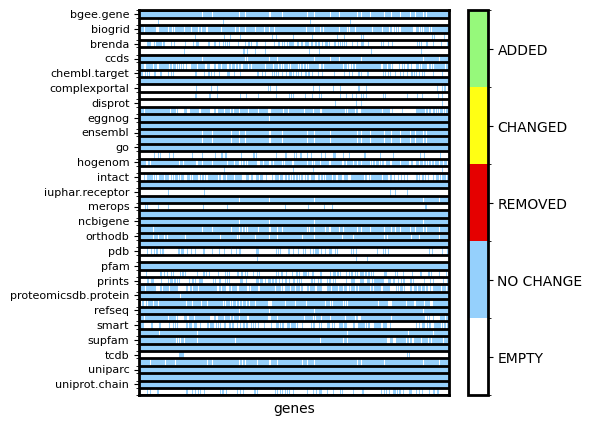

In [27]:
for col, series in df_isoforms_chains.items():
    df_annotations[col] = series

for idx, row in df_annotations.loc[:, annotation_columns].iterrows():
    uniprot_id, isoform_id = df_isoforms_chains.loc[idx, ["uniprot", "uniprot.isoform"]]
    if isoform_id and len(isoform_id.split(";")) != 1:
        isoform_id = None
    # No isoform ID set, just aggregate all without regards to isoform.
    row = row.apply(
        lambda x: (
            get_isoform_value_from_entry_UniProt(x, isoform_id)
            if get_isoform_value_from_entry_UniProt(x, isoform_id).strip()
            else x
        )
    )
    row = row.apply(lambda x: x.strip().rstrip(";"))
    # A duplicate reindexing error may here may mean duplicate columns in annotation column values
    df_annotations.loc[idx, annotation_columns] = row.values
# Clean up other annotations
keys = ["rhea", "go", "hgnc"]
for key in keys:
    if key in df_annotations.columns:
        df_annotations[key] = (
            df_annotations[key]
            .fillna("")
            .apply(
                lambda x: build_string(
                    [s.lstrip(f"{key.upper()}:") for s in split_string(x)]
                )
            )
        )


df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            database_dirpath / f"{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")
if overwrite:
    df_annotations.to_csv(
        database_dirpath / f"{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )

df_annotations

## Load Isoforms and Sequences
### Isoforms
#### Parse data into initial table of isoforms

In [28]:
erythro_keywords = [
    "erythro",
    "erythrocyte",
    "erythroid",
    "red blood cell",
    "rbc",
    "R-type",
    "P5N-I",
    "reticulocyte",
]
backup_keywords = ["cyto", "retic", "cell membrane"]
avoid_keywords = ["non-erythro", "mito", "not detected", "synaptic", "testis"]

rename_mapping = {
    "Entry": "uniprot",
    "Gene Names (primary)": "hgnc.symbol",
    "Organism (ID)": "taxonomy",
    "Alternative products (isoforms)": "uniprot.isoform",
    "Tissue specificity": "tissue_specificity",
    "Subcellular location [CC]": "subcellular_location",
}
columns_to_search = ["tissue_specificity", "subcellular_location"]

df_tissue_specificity = (
    df_query_results.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1).copy()
)
df_isoforms = parse_isoforms_UniProt(
    df_tissue_specificity.loc[:, ["uniprot", "uniprot.isoform"]].copy(),
    add_canonical=True,
)
df_isoforms = df_isoforms.merge(
    df_tissue_specificity[columns_to_search],
    left_on="uniprot",
    right_index=True,
    how="left",
)

df_isoforms["erythroid"] = pd.NA
df_isoforms["backup"] = pd.NA
df_isoforms["avoid"] = pd.NA
df_isoforms["keywords.erythroid"] = pd.NA
df_isoforms["keywords.backup"] = pd.NA
df_isoforms["keywords.avoid"] = pd.NA
all_names = sorted(
    df_isoforms["uniprot.isoform.name"].replace("", pd.NA).dropna().unique()
)
all_synonyms = sorted(
    df_isoforms["uniprot.isoform.synonyms"].replace("", pd.NA).dropna().unique()
)
for col_to_search in columns_to_search:
    for idx, value_string in df_isoforms[col_to_search].dropna().items():
        if not re.search(r"\[Isoform (.+?(?=\]))", value_string):
            continue
        for isoform_entry in value_string.split(";"):
            match = re.search(r"\[Isoform (.+?(?=\]))", isoform_entry)
            if not match:
                continue

            isoform_name_or_synonym = match.group(1)
            if not (
                df_isoforms.loc[idx, "uniprot.isoform.name"] == isoform_name_or_synonym
                or df_isoforms.loc[idx, "uniprot.isoform.synonyms"]
                == isoform_name_or_synonym
            ):
                continue

            for col, keywords in zip(
                ["erythroid", "backup", "avoid"],
                [erythro_keywords, backup_keywords, avoid_keywords],
            ):
                found_keywords = set()
                for k in keywords:
                    found_keywords.update(
                        re.findall(k, isoform_entry.strip(), re.IGNORECASE)
                    )
                if df_isoforms.fillna("").loc[idx, f"keywords.{col}"]:
                    found_keywords.update(
                        split_string(df_isoforms.loc[idx, f"keywords.{col}"])
                    )
                df_isoforms.loc[idx, f"keywords.{col}"] = build_string(found_keywords)

for col, keywords in zip(
    ["erythroid", "backup", "avoid"],
    [erythro_keywords, backup_keywords, avoid_keywords],
):
    df_isoforms[f"keywords.{col}"] = df_isoforms[f"keywords.{col}"].apply(
        lambda x: set(split_string(x)) if isinstance(x, str) else set()
    )
    for k in keywords:
        df_isoforms[f"keywords.{col}"] = (
            df_isoforms[[f"keywords.{col}", "uniprot.isoform.name"]]
            .fillna("")
            .apply(
                lambda x: x[f"keywords.{col}"].union(
                    set(re.findall(k, x["uniprot.isoform.name"], re.IGNORECASE))
                ),
                axis=1,
            )
        )
        df_isoforms[f"keywords.{col}"] = (
            df_isoforms[[f"keywords.{col}", "uniprot.isoform.synonyms"]]
            .fillna("")
            .apply(
                lambda x: x[f"keywords.{col}"].union(
                    set(re.findall(k, x["uniprot.isoform.synonyms"], re.IGNORECASE))
                ),
                axis=1,
            )
        )
    df_isoforms[f"keywords.{col}"] = df_isoforms[f"keywords.{col}"].apply(
        lambda x: build_string([s for s in x if s])
    )
df_isoforms = df_isoforms.replace(float("nan"), pd.NA).replace("", pd.NA)
df_isoforms["erythroid"] = df_isoforms["keywords.erythroid"].notna()
df_isoforms["backup"] = df_isoforms["keywords.backup"].notna()
df_isoforms["avoid"] = df_isoforms["keywords.avoid"].notna()
# Remove those found in both categories from "erythroid", usually caused by words like `non-erythro`
df_isoforms.loc[
    df_isoforms[df_isoforms[["erythroid", "avoid"]].all(axis=1)].index,
    "erythroid",
] = False
# Erythroid easily serves as a backup option
df_isoforms.loc[
    df_isoforms[df_isoforms[["erythroid"]].all(axis=1)].index,
    "backup",
] = True

df_isoforms["canonical"] = df_isoforms["uniprot.canonical"]
df_isoforms["sequence.id"] = df_isoforms.fillna("").apply(
    lambda x: x["uniprot.isoform"] if x["uniprot.isoform"] else x["uniprot"], axis=1
)
df_isoforms = df_isoforms.replace(float("nan"), pd.NA).replace("", pd.NA)
df_isoforms = (
    df_isoforms.loc[
        :,
        [
            "uniprot",
            "uniprot.isoform",
            "sequence.id",
            "canonical",
            "erythroid",
            "backup",
            "avoid",
            "keywords.erythroid",
            "keywords.backup",
            "keywords.avoid",
        ],
    ]
    .drop_duplicates()
    .reset_index(drop=True)
)

### Sequences
#### Extract sequences using UniParc Mapping

In [29]:
df_isoforms_sequences = df_isoforms[
    df_isoforms.apply(lambda x: x["sequence.id"].startswith(x["uniprot"]), axis=1)
].copy()
query_ids = df_isoforms_sequences["sequence.id"].unique()

query_parameters = {
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(
        [
            "sequence",
            "length",
        ]
    ),
}

query_key = "initial"
df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    list(query_ids),
    query_parameters=query_parameters,
    from_db="UniProtKB_AC-ID",
    to_db="UniParc",
    return_failed=True,
)

if failed_ids:
    print(failed_ids)

df_isoforms_sequences = df_isoforms_sequences.merge(
    df_results.set_index("From").rename(
        {
            "Sequence": "sequence",
            "Length": "sequence.length",
            "mass": "sequence.mass",
        },
        axis=1,
    ),
    left_on="sequence.id",
    right_index=True,
)

# #  The following code can be used to address entries with issues in extractions. LDHB example.
# df_isoforms_sequences = pd.concat(
#     (
#         df_isoforms_sequences,
#         pd.DataFrame.from_dict(
#             {
#                 "uniprot": "P07195",
#                 "sequence.id": "P07195",
#                 "canonical": True,
#                 "erythroid": False,
#                 "backup": False,
#                 "avoid": False,
#                 "sequence": "MATLKEKLIAPVAEEEATVPNNKITVVGVGQVGMACAISILGKSLADELALVDVLEDKLKGEMMDLQHGSLFLQTPKIVADKDYSVTANSKIVVVTAGVRQQEGESRLNLVQRNVNVFKFIIPQIVKYSPDCIIIVVSNPVDILTYVTWKLSGLPKHRVIGSGCNLDSARFRYLMAEKLGIHPSSCHGWILGEHGDSSVAVWSGVNVAGVSLQELNPEMGTDNDSENWKEVHKMVVESAYEVIKLKGYTNWAIGLSVADLIESMLKNLSRIHPVSTMVKGMYGIENEVFLSLPCILNARGLTSVINQKLKDDEVAQLKKSADTLWDIQKDLKDL",
#                 "sequence.length": "334",
#             },
#             orient="index",
#         ).T,
#     ),
#     axis=0,
# ).convert_dtypes()

df_isoforms_sequences = df_isoforms_sequences.reset_index(drop=True)

if overwrite:
    df_isoforms_sequences.to_csv(
        database_dirpath / f"{UNIPROT_DB_TAG}_isoforms_sequences.tsv",
        sep="\t",
        index=False,
    )

df_isoforms_sequences

Fetched: 500 / 1105
Fetched: 1000 / 1105


Number of failed query IDs : 3


Fetched: 1105 / 1105


Number of failed IDs : 3


{'P53657-2', 'P63005-2', 'P21836-2'}


,uniprot,uniprot.isoform,sequence.id,canonical,erythroid,backup,avoid,keywords.erythroid,keywords.backup,keywords.avoid,sequence,sequence.length
0,A1L3P4,<NA>,A1L3P4,True,False,False,False,<NA>,<NA>,<NA>,MAGARRGWRLAPVRRGVCGPRARPLMRPLWLLFAVSFFGWTGALDG...,702
1,A2A432,A2A432-1,A2A432-1,True,False,False,False,<NA>,<NA>,<NA>,MSRSTRSKERRENDTDSEDNSSETSNQERRRCRQGPPRPPYPPLLP...,970
2,A2A432,A2A432-2,A2A432-2,False,False,False,False,<NA>,<NA>,<NA>,MSRSTRSKERRENDTDSEDNSSETSNQERRRCRQGPPRPPYPPLLP...,941
3,A2ALK8,<NA>,A2ALK8,True,False,False,False,<NA>,<NA>,<NA>,MTSRLRALGGRINNTRTSELPKEKTRSEVICSIRFLDGLVQTFKVN...,913
4,A2AN08,A2AN08-1,A2AN08-1,True,False,False,False,<NA>,<NA>,<NA>,MATSGGEEAAAAAPAPGAPATGQDTTPGWEVAVRPLLSASYSAFEM...,5180
...,...,...,...,...,...,...,...,...,...,...,...,...
1100,Q9Z2L6,<NA>,Q9Z2L6,True,False,False,False,<NA>,<NA>,<NA>,MLRGARSHLPASVAPAAVLAAALLSSFARCSLPGRGDPVASVLSPY...,481
1101,Q9Z2M7,<NA>,Q9Z2M7,True,False,False,False,<NA>,<NA>,<NA>,MATLCLFDMDGTLTAPRQKITEEMDGFLQKLRQKTKIGVVGGSDFE...,242
1102,Q9Z2V4,<NA>,Q9Z2V4,True,False,False,False,<NA>,<NA>,<NA>,MPPQLHNGLDFSAKVIQGSLDSLPQAVRKFVEGNAQLCQPEYIHIC...,622
1103,Q9Z2W0,<NA>,Q9Z2W0,True,False,False,False,<NA>,<NA>,<NA>,MAMNGRARKEAIQATARELLKFVNRSPSPFHVVAECRSRLLQAGFR...,473


In [30]:
df_model_mappings.merge(df_isoforms_sequences[df_isoforms_sequences["erythroid"]])

,genes,uniprot,uniprot.isoform,sequence.id,canonical,erythroid,backup,avoid,keywords.erythroid,keywords.backup,keywords.avoid,sequence,sequence.length
0,Hmbs,P22907,P22907-2,P22907-2,False,True,True,False,Erythrocyte;Erythro,<NA>,<NA>,MRVIRVGTRKSQLARIQTDTVVAMLKALYPGIQFEIIAMSTTGDKI...,344
1,Pklr,P53657,P53657-1,P53657-1,True,True,True,False,R-type,<NA>,<NA>,MSVQENELPQQLWPWIFKSQKDLAKSALSGAPGGPAGYLRRASVAQ...,574
2,Slc11a2,P49282,P49282-2,P49282-2,False,True,True,False,erythro;erythroid,<NA>,<NA>,MVLDPKEKMPDDGASGDHGDSASLGAINPAYSNSSLPHSTGDSEEP...,561
3,Slc4a1,P04919,P04919-1,P04919-1,True,True,True,False,Erythrocyte;Erythro,<NA>,<NA>,MGDMRDHEEVLEIPDRDSEEELENIIGQIAYRDLTIPVTEMQDPEA...,929
